# CAFEPP (utilising cafepp_daily(.py))

***

## This example will produce a set of nino3.4 indice files (average of SST over the nino3.4 region) across the V1 assimilation run, and upon success, plot the time-series.

The system is designed to process any experiment and any diagnostic (for which there is valid raw data). So, for example, by chosing a different **cafepp_experiment** (set in **cafepp.json** and available choices in **cafepp_experiments.json**, currently set to **coupled_da/OUTPUT-2step-nobreeding-carbon2** the v2 assimilation run) you will get nino3.4 across its valid daily input. By changing **dvar** you can generate another diagnostic (e.g. **thetao** will give the depth weighted ocean temperature) across the same experiment.

Currently the monthly version **cafepp(.py)** is unavailable. I am planning to modify the way in which it looks for input files, similar to cafepp_daily.py, to simplify its operation. I will notify you when it is back online.


***

# Various settings required:

## BATCH determines whether it will be sent to the queue via qsub command or run interactively.

## CLEAN determines whether the run directory will be emptied prior to processing.

***

# Software:

Recommend *conda* be used to manage your pythong environment. Major modules required are (on *raijin* you might be able to access my conda environment, I have called this **cafepp_27_scipy**):

- numpy
- numpy.ma
- netCDF4
- seawater
- cmor
- cdms2
- json
- scipy.sparse
- matplotlib
- gridfill (I needed to do a python install on top of my conda environment to get this to work).

Currently **cmor(3)** is maintained under *python2* and it is unlikely to be available under python3 for some time, even as a test product. The reason for this is presumably that the main development has finished and the group mostly behind it (PCMDI) have no time for this currently, and they want to ensure that CMIP5 (and other) modelling groups do not find themselve having to rewrite cmor processed datasets due to a bug or technical issues arising from a python2->python3 port.



In [8]:
from __future__ import print_function #this is to allow print(,file=xxx) feature

import datetime
import shutil
import os

BATCH=True #submit to queue
BATCH=False #run interactively but in a batch temporary area.

CLEAN=False #don't remove rundir, just use it.
CLEAN=True #remove rundir and recreate it.

if(BATCH):
  print('Submitting to queue.')

if(CLEAN):
  print('Removing run directory and reestablish it.')

predir='/short/v14/mac599'
topdir=predir+'/'+'cafepp'
script='cafepp_daily_assimilation_year_month.py'

rundir=topdir+'/'+'rundir20171124143249'
rundir=topdir+'/'+'rundir20171128165302'
rundir=topdir+'/'+'rundir'+datetime.datetime.today().strftime('%Y%m%d%H%M%S')
rundir=topdir+'/'+'rundir' #temporary running directory

print('Running in directory '+rundir)
print('Using script '+script)

srcdir='/home/599/mac599/decadal' #main cafepp code
prodir=srcdir+'/paper_analysis' #project directory


Removing run directory and reestablish it.
Running in directory /short/v14/mac599/cafepp/rundir
Using script cafepp_daily_assimilation_year_month.py


# Here we make directories, copy across necessary JSON and python code.

In [2]:
print('copying json files, generating symlinks, cmor tables, queue script, if necessary.')
if(os.path.exists(rundir) and CLEAN):
  shutil.rmtree(rundir)
  os.mkdir(rundir)
  os.mkdir(rundir+'/'+'JsonTemplates') # exist_ok=True only python3
elif(not os.path.exists(rundir)):
  os.mkdir(rundir)
  os.mkdir(rundir+'/'+'JsonTemplates') # exist_ok=True only python3

os.symlink(predir+'/'+'CMIP6',rundir+'/'+'CMIP6')
os.symlink(prodir+'/'+'TablesTemplates',rundir+'/'+'TablesTemplates')
os.symlink(prodir+'/'+'cmip6-cmor-tables',rundir+'/'+'cmip6-cmor-tables')

if(BATCH):
  ifh=open(prodir+'/'+'qjob.csh')
  ofh=open(rundir+'/'+'qjob.csh','w')
  for i,line in enumerate(ifh):
    line=line.replace('RUNDIR',rundir)
    print(line,file=ofh,end='')
  ifh.close()
  ofh.close()

vector_string=['decadal_diag.py','cafepp_daily.py','app_funcs.py']
for i,file_now in enumerate(vector_string):
  print('Copying '+srcdir+'/'+file_now+' to ',rundir)
  shutil.copyfile(srcdir+'/'+file_now,rundir+'/'+file_now)

vector_string=['cafepp_daily_assimilation_year_month.py']
for i,file_now in enumerate(vector_string):
  print('Copying '+prodir+'/'+file_now+' to ',rundir)
  shutil.copyfile(prodir+'/'+file_now,rundir+'/'+file_now)
  
vector_string=[]
vector_string.append(script) #may need to do edits?
vector_string.append('cafepp_daily_assimilation.json')
vector_string.append('cafepp_daily_forecast_experiments.json')
vector_string.append('JsonTemplates'+'/'+'cafepp_csiro-gfdl.json')
vector_string.append('JsonTemplates'+'/'+'cafepp_vars.json')

for i,file_now in enumerate(vector_string):
  print('Copying '+prodir+'/'+file_now+' to ',rundir)
  shutil.copyfile(prodir+'/'+file_now,rundir+'/'+file_now)

copying json files, generating symlinks, cmor tables, queue script, if necessary.
Copying /home/599/mac599/decadal/decadal_diag.py to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/cafepp_daily.py to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/app_funcs.py to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/cafepp_daily_assimilation_year_month.py to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/cafepp_daily_assimilation_year_month.py to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/cafepp_daily_assimilation.json to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/cafepp_daily_forecast_experiments.json to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/JsonTemplates/cafepp_csiro-gfdl.json to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/JsonTemplat

# We establish where to execute the job.

## We import a function that is relatively simple to loop over all necessary years, months, ensembles as required.
## Different applications will require a different module to be written (often small and relatively simple).

In [3]:
os.chdir(rundir)
print('Current Working Directory=',os.getcwd())

import getpass
import numpy as np
import numpy.ma as ma
import os
from time import strftime
import netCDF4
from math import radians, cos, sin, asin, sqrt
import seawater
#import sys
import getopt
import string
from decadal_diag import MustHaveAllLevs,diag_acc_drake,diag_acc_africa,diag_mozmbq,diag_aabw,diag_nadw,\
diag_pp,diag_nflux,diag_ep,diag_ssh,diag_moc,diag_moc_atlantic,diag_moc_pacific,diag_moc_indian,\
diag_shice_cover,diag_nhice_cover,diag_nino34,xtra_nino34,init_data,sum_data,avg_data,filemonth_index,\
data_wavg,time_avg,diag_nhblocking_index,diag_rws5,finish,diag_msftyyz,make_mask3D,diag_mfo,transPort,\
diag_rws500,create_odirs,create_ofils,diag_iod,diag_iod,xtra_iod,atmos_vertical_interpolate,diag_isothetaoNc,\
calc_iso_surface,calc_isoN,grab_var_meta,diag_psl,diag_hfls,diag_heat_content,diag_salt_content,\
diag_north_heat_trans,diag_north_salt_trans,ocean_vertical_interpolate,diag_thetao0to80m,diag_varNl,\
uncomment_json,process_json,get_daily_indices_for_monthlyave,diag_maxdTbydz,diag_depmaxdTbydz,\
diag_dTbydz,shade_2d_simple,shade_2d_latlon,diag_zmld_boyer,zmld_boyer,sigmatheta,diag_zmld_so,\
zmld_so,diag_spice,spice,diag_bigthetao,diag_soabs,diag_spiciness,diag_potrho,fractional_year_from_num2date,\
new_monthly_array_shape

import cmor
import cdtime
from app_funcs import *
import json
import pprint
from datetime import date
import filecmp
from shutil import copyfile
import cdms2
import inspect
import socket
import glob
from matplotlib.mlab import griddata
import scipy.sparse as sps
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'regular'
import matplotlib.pyplot as plt
from gridfill import fill as poisson_fill

import cafepp_daily_assimilation_year_month

Current Working Directory= /short/v14/mac599/cafepp/rundir
you have not specified the environment variable: 'CDAT_LOCATION' , trying to import cdms2 anyway


# Either submit it to the queue or run interactively.

In [4]:
if(BATCH):
  os.chmod(script,500)
  os.system('qsub '+rundir+'/'+'qjob.csh')
else:
  print('Current Working Directory=',os.getcwd())
  os.chdir(rundir)
  cafepp_daily_assimilation_year_month.main(rundir)

Current Working Directory= /short/v14/mac599/cafepp/rundir
ybeg_now,mbeg_now= 2002 1
MAIN
hostname= raijin6
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f073491ba10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-edf1d412-a83f-41f3-9376-edee7d0dece0.json']
Found required output variable: nino34
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20020101-20020131.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20020101-20020131.nc  exists
ybeg_now,mbeg_now= 2002 2
MAIN
hostname= raijin6
Running cafepp from JSON instruc

Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20021201-20021231.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20021201-20021231.nc  exists
ybeg_now,mbeg_now= 2003 1
MAIN
hostname= raijin6
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f073491ba10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-edf1d412-a83f-41f3-9376-edee7d0dece0.json']
Found required output variable: nino34
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_200301

Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20031201-20031231.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20031201-20031231.nc  exists
ybeg_now,mbeg_now= 2004 1
MAIN
hostname= raijin6
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f073491ba10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-edf1d412-a83f-41f3-9376-edee7d0dece0.json']
Found required output variable: nino34
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_200401

Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-edf1d412-a83f-41f3-9376-edee7d0dece0.json']
Found required output variable: nino34
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20041101-20041130.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20041101-20041130.nc  exists
ybeg_now,mbeg_now= 2004 12
MAIN
hostname= raijin6
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f073491ba10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/m

Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20050901-20050930.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20050901-20050930.nc  exists
ybeg_now,mbeg_now= 2005 10
MAIN
hostname= raijin6
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f073491ba10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-edf1d412-a83f-41f3-9376-edee7d0dece0.json']
Found required output variable: nino34
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20051

Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20060701-20060731.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20060701-20060731.nc  exists
ybeg_now,mbeg_now= 2006 8
MAIN
hostname= raijin6
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f073491ba10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-edf1d412-a83f-41f3-9376-edee7d0dece0.json']
Found required output variable: nino34
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_200608

Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-edf1d412-a83f-41f3-9376-edee7d0dece0.json']
Found required output variable: nino34
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20070701-20070731.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20070701-20070731.nc  exists
ybeg_now,mbeg_now= 2007 8
MAIN
hostname= raijin6
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f073491ba10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/ma

Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-edf1d412-a83f-41f3-9376-edee7d0dece0.json']
Found required output variable: nino34
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20080501-20080531.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20080501-20080531.nc  exists
ybeg_now,mbeg_now= 2008 6
MAIN
hostname= raijin6
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f073491ba10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/ma

Found required output variable: nino34
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20090401-20090430.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20090401-20090430.nc  exists
ybeg_now,mbeg_now= 2009 5
MAIN
hostname= raijin6
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f073491ba10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-edf1d412-a83f-41f3-9376-edee7d0dece0.json']
Found required output variable: nino34
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday

Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-edf1d412-a83f-41f3-9376-edee7d0dece0.json']
Found required output variable: nino34
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20100301-20100331.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20100301-20100331.nc  exists
ybeg_now,mbeg_now= 2010 4
MAIN
hostname= raijin6
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f073491ba10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/ma

Found required output variable: nino34
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20110101-20110131.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20110101-20110131.nc  exists
ybeg_now,mbeg_now= 2011 2
MAIN
hostname= raijin6
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f073491ba10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-edf1d412-a83f-41f3-9376-edee7d0dece0.json']
Found required output variable: nino34
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday

Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-edf1d412-a83f-41f3-9376-edee7d0dece0.json']
Found required output variable: nino34
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20120101-20120131.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20120101-20120131.nc  exists
ybeg_now,mbeg_now= 2012 2
MAIN
hostname= raijin6
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f073491ba10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/ma

Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20121201-20121231.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20121201-20121231.nc  exists
ybeg_now,mbeg_now= 2013 1
MAIN
hostname= raijin6
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f073491ba10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-edf1d412-a83f-41f3-9376-edee7d0dece0.json']
Found required output variable: nino34
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_201301

MAIN
hostname= raijin6
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f073491ba10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-edf1d412-a83f-41f3-9376-edee7d0dece0.json']
Found required output variable: nino34
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20131101-20131130.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20131101-20131130.nc  exists
ybeg_now,mbeg_now= 2013 12
MAIN
hostname= raijin6
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f073491b

Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20140901-20140930.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20140901-20140930.nc  exists
ybeg_now,mbeg_now= 2014 10
MAIN
hostname= raijin6
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f073491ba10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-edf1d412-a83f-41f3-9376-edee7d0dece0.json']
Found required output variable: nino34
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20141

Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-edf1d412-a83f-41f3-9376-edee7d0dece0.json']
Found required output variable: nino34
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20150801-20150831.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_20150801-20150831.nc  exists
ybeg_now,mbeg_now= 2015 9
MAIN
hostname= raijin6
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f073491ba10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/ma

# Now to plot data, this will depend on success of previous steps producing necessary outputs with cafepp(_daily).

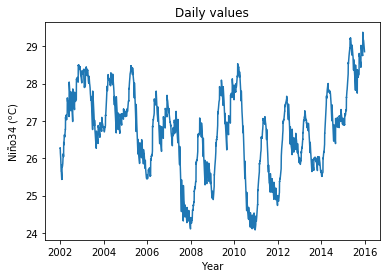

In [5]:
os.chdir(rundir)

files=sorted(glob.glob('/short/v14/mac599/CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/nino34/gn/v20171025/nino34_Oday_historical_CAFE-1-0_r1i1p2f1_gn_????????-????????.nc'))
ifhN=netCDF4.MFDataset(files)
nino34=ifhN.variables['nino34']
time=ifhN.variables['time']

'''
print('time.units=',time.units)
print('time.calendar=',time.calendar)
print('time=',time)
print('time[:]=',time[:])
'''

date_time_stamp=netCDF4.num2date(time[:],time.units,time.calendar)

'''
print('date_time_stamp=',date_time_stamp)
num_stamp=netCDF4.date2num(date_time_stamp,time.units,time.calendar)
print('num_stamp=',num_stamp)
print('year_fraction=',year_fraction)
'''
year_fraction=fractional_year_from_num2date(date_time_stamp,time.calendar)

%matplotlib inline

plt.title('Daily values')
#plt.plot(num_stamp,nino34[:])
plt.plot(year_fraction,nino34[:])
plt.xlabel('Year')
plt.ylabel('Ni$\~{n}$o34 ($^o$C)')
plt.show()

In the following monthly values will be calculated and then plotted.

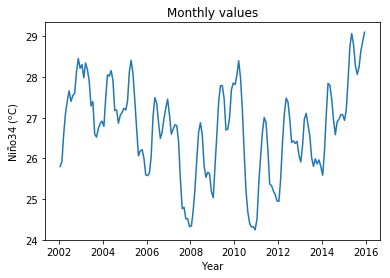

In [6]:
indices=get_daily_indices_for_monthlyave(time,date_time_stamp,time.calendar) #a list
nino34_monthly=np.zeros(len(indices))
for month in range(0,len(indices)):
  nino34_monthly[month]=np.average(nino34[indices[month]])

year_fraction_monthly=np.zeros(len(indices))
for month in range(0,len(indices)):
  year_fraction_monthly[month]=np.average(year_fraction[indices[month]])
  
%matplotlib inline

plt.plot(year_fraction_monthly,nino34_monthly)
plt.title('Monthly values')
plt.xlabel('Year')
plt.ylabel('Ni$\~{n}$o34 ($^o$C)')
plt.show()

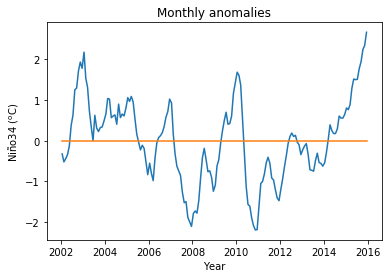

In [7]:
ybeg=date_time_stamp[0].year
yend=date_time_stamp[-1].year
ydiff=yend-ybeg+1
#print('ydiff=',ydiff)
nmy=12

nino34_monthly_reshaped=np.reshape(nino34_monthly,new_monthly_array_shape(nino34_monthly.shape,ydiff,nmy))
climatology=np.average(nino34_monthly_reshaped,axis=0)
nino34_monthly_climatology=np.expand_dims(climatology,0)
nino34_monthly_climatology=np.tile(nino34_monthly_climatology,(ydiff,1))
nino34_monthly_climatology_flat=nino34_monthly_climatology.flatten()
nino34_monthly_anomaly=nino34_monthly-nino34_monthly_climatology_flat

%matplotlib inline

zero=np.zeros(len(indices))
plt.plot(year_fraction_monthly,nino34_monthly_anomaly)
plt.plot(year_fraction_monthly,zero)

plt.title('Monthly anomalies')
plt.xlabel('Year')
plt.ylabel('Ni$\~{n}$o34 ($^o$C)')
plt.show()